In [1]:
######## Utilità generali #############################

import numpy as np # algebra e manipolazione di vettori (array) di dati
import scipy # analisi e manipolazione di funzioni (integrali, derivate, equazioni, interpolazioni...)

######### Grafica #####################################

%matplotlib inline
import matplotlib.pyplot as plt # per la grafica

    
# Latex: per impostare la grafica "come se fosse un vero articolo scientifico"
font = {'size'   : 25, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True
np.set_printoptions(precision=3,linewidth=200,suppress=False)

In [2]:
# Cosmologia

import halomod
from halomod import DMHaloModel

import hmf
#HMF
from hmf import cosmology
from hmf import density_field
from hmf import Transfer


import powerbox as pbox

/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


In [4]:
ref_Om_0 = hmf.cosmo.Planck15.Om0

# Generiamo cosmologia di riferimento

hm_ref = DMHaloModel()

redshift = 0.

hm_ref.z = redshift
hm_ref.cosmo_params['OmO'] = ref_Om_0


hm_ref.tracer_profile_model = "NFW" # Primo ingrediente: profilo di densità dell'alone di materia oscura
# Navarro - Frenk - White, lo standard più comune

hm_ref.bias_model = 'ST99'  # Secondo ingrediente, il "bias dell'alone"

hm_ref.hmf_model = 'ST' # Terzo ingrediente: la funzione di massa, quanti (in numero) aloni abbiamo nell'universo per ogni valore di massa dell'alone?

modi_k = np.logspace(-4,3,200) # Generiamo più modi di quelli che halomod normalmente associa agli spettri (pur calcolando il valore dello spettro corrispondente), servirà dopo

# Genero lo spettro di potenza, termini 1halo, 2halo e complessivo

index_1h_max = np.where(hm_ref.power_1h_auto_matter_fnc(modi_k) == np.max(hm_ref.power_1h_auto_matter_fnc(modi_k)))[0] 


max_val_1h = np.max(hm_ref.power_1h_auto_matter_fnc(modi_k)) # valore corrispondente

# Ridefinisco la funzione del 1halo a tratti, in modo che a grandi scale (piccoi k) restituisca un plateau

def pk_1halo_corretto(k,pk):
    
    return np.piecewise(k, [k < modi_k[index_1h_max],k >= modi_k[index_1h_max] ], [lambda x: max_val_1h ,lambda x :pk.power_1h_auto_matter_fnc(x)])



In [5]:
# Generazione della simulazione di riferimento, LCDM

boxlength = 1000
N = 256
#print('Massimo k campionato: ',np.pi * N / boxlength, 'h / Mpc')
#print('Minima scala campionata:', boxlength/N, 'h / Mpc')
# Ovvero, scale più piccole delle scale tipiche degli ammassi di galassie, "vediamo" la non linearità 
# dello spettro di potenza

# Sezione bidimensionale di una simulazione a dato redshift

lnpb_ref_tot = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: hm_ref.power_auto_matter_fnc(k), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

lnpb_ref_2h = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: hm_ref.power_2h_auto_matter_fnc(k), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

lnpb_ref_1h = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: pk_1halo_corretto(k,hm_ref), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/halomod/tools.py:653: UserWarning: You are using an un-normalized mass function and bias function pair.Bias ST99 has the following paired HMF model: (<class 'hmf.mass_function.fitting_functions.SMT'>,). Matter correlations are not well-defined.
  warnings.warn(


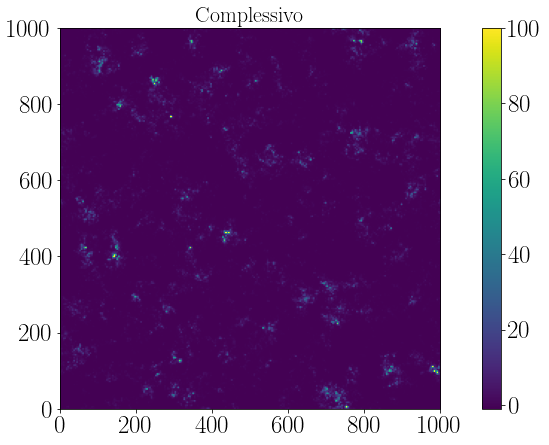

In [6]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('Complessivo',size=22)

plt.imshow(lnpb_ref_tot.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

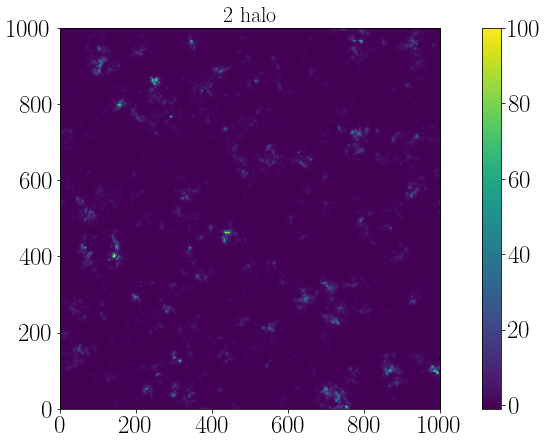

In [9]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('2 halo',size=22)

plt.imshow(lnpb_ref_2h.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

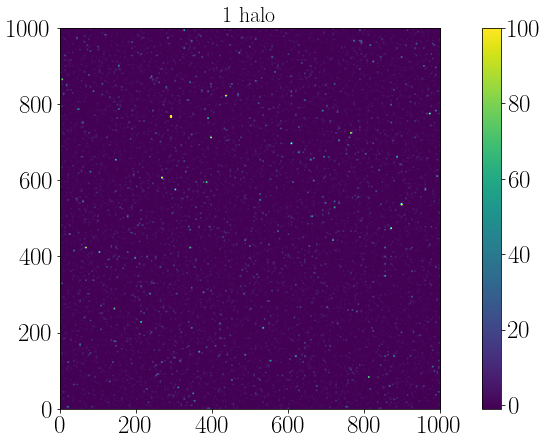

In [10]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('1 halo',size=22)

plt.imshow(lnpb_ref_1h.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

In [11]:
pb = pbox.LogNormalPowerBox(N=N, dim=3, pk = lambda k: hm_ref.power_auto_matter_fnc(k), boxlength= boxlength, seed=1234,ensure_physical=True)

In [12]:
deltax = pb.delta_x() # altra cosa importante: ci vuole del tempo...

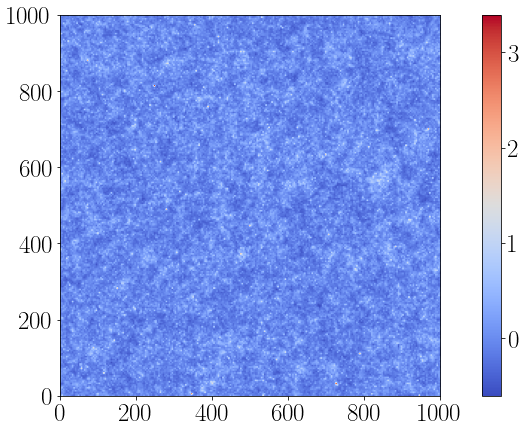

In [14]:
plt.figure(figsize=(15,7))

plt.imshow(np.mean(deltax[:,:,:],axis=0),extent=(0,boxlength,0,boxlength),cmap='coolwarm',) # capire che cosa si intende
plt.colorbar()
plt.show()

[]

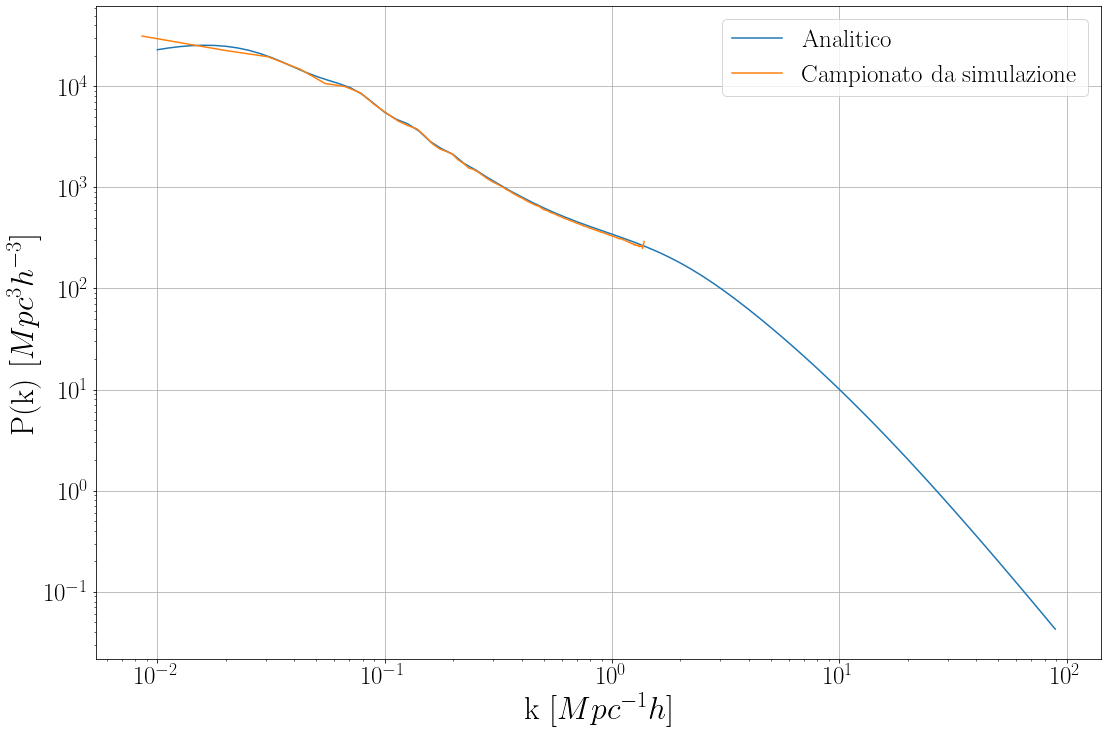

In [15]:
# Estraggo lo spettro di potenza dalla simulazione, 

p_k, kbins = pbox.get_power(deltax,pb.boxlength,)#,bins = 80)


plt.figure(figsize=(18,12))
plt.loglog(hm_ref.k_hm, hm_ref.power_auto_matter_fnc(hm_ref.k_hm), label='Analitico')
plt.plot(kbins,p_k,label="Campionato da simulazione")

plt.grid()
plt.legend(fontsize=25)
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.ylabel(r" P(k)$  \ [{ Mpc^3}h^{-3}]$",size=32);
plt.loglog()
#plt.ylim(1e-4,1e4)

#plt.xlim(2*1e-2,1)

In [45]:
ref_Om_0 = hmf.cosmo.Planck15.Om0
ref_Ob_0 = hmf.cosmo.Planck15.Ob0
ref_H_0 = hmf.cosmo.Planck15.H0

# Generiamo cosmologia di riferimento

hm_alt = DMHaloModel(cosmo_params = {
        'Om0': 0.7,
        'H0': 46.0})

redshift = 0.

hm_alt.z = redshift
#hm_alt.cosmo_params['OmO'] = ref_Om_0#/2
#hm_alt.cosmo_params['ObO'] = ref_Ob_0#*15
#hm_alt.cosmo_params['H0'] = ref_H_0#*15
hm_alt.sigma_8 = 1.4

hm_alt.tracer_profile_model = "NFW" # Primo ingrediente: profilo di densità dell'alone di materia oscura
# Navarro - Frenk - White, lo standard più comune

hm_alt.bias_model = 'ST99'  # Secondo ingrediente, il "bias dell'alone"

hm_alt.hmf_model = 'ST' # Terzo ingrediente: la funzione di massa, quanti (in numero) aloni abbiamo nell'universo per ogni valore di massa dell'alone?

modi_k = np.logspace(-4,3,200) # Generiamo più modi di quelli che halomod normalmente associa agli spettri (pur calcolando il valore dello spettro corrispondente), servirà dopo

# Genero lo spettro di potenza, termini 1halo, 2halo e complessivo

index_1h_max = np.where(hm_alt.power_1h_auto_matter_fnc(modi_k) == np.max(hm_alt.power_1h_auto_matter_fnc(modi_k)))[0] 


max_val_1h = np.max(hm_alt.power_1h_auto_matter_fnc(modi_k)) # valore corrispondente

# Ridefinisco la funzione del 1halo a tratti, in modo che a grandi scale (piccoi k) restituisca un plateau

def pk_1halo_corretto(k,pk):
    
    return np.piecewise(k, [k < modi_k[index_1h_max],k >= modi_k[index_1h_max] ], [lambda x: max_val_1h ,lambda x :pk.power_1h_auto_matter_fnc(x)])



In [46]:
# Generazione della simulazione di riferimento, LCDM

boxlength = 1000
N = 256
#print('Massimo k campionato: ',np.pi * N / boxlength, 'h / Mpc')
#print('Minima scala campionata:', boxlength/N, 'h / Mpc')
# Ovvero, scale più piccole delle scale tipiche degli ammassi di galassie, "vediamo" la non linearità 
# dello spettro di potenza

# Sezione bidimensionale di una simulazione a dato redshift

lnpb_alt_tot = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: hm_alt.power_auto_matter_fnc(k), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

lnpb_alt_2h = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: hm_alt.power_2h_auto_matter_fnc(k), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

lnpb_alt_1h = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: pk_1halo_corretto(k,hm_alt), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

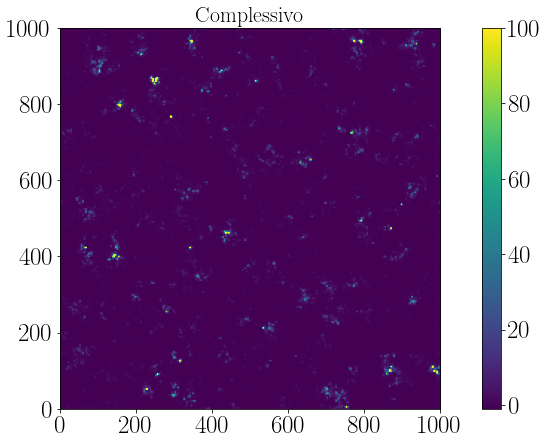

In [47]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('Complessivo',size=22)

plt.imshow(lnpb_alt_tot.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

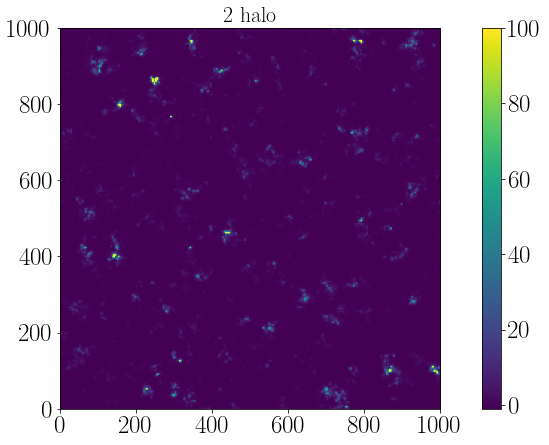

In [48]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('2 halo',size=22)

plt.imshow(lnpb_alt_2h.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

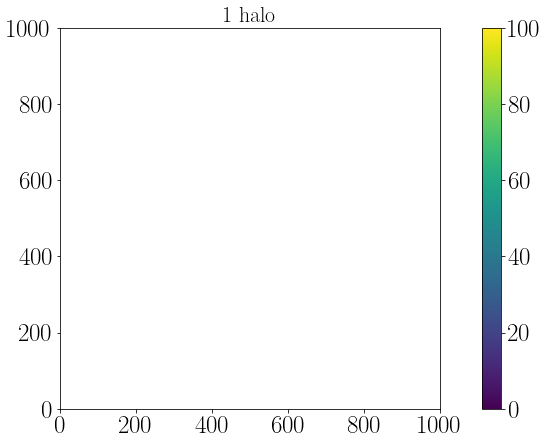

In [49]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('1 halo',size=22)

plt.imshow(lnpb_alt_1h.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

In [50]:
pb = pbox.LogNormalPowerBox(N=N, dim=3, pk = lambda k: hm_alt.power_auto_matter_fnc(k), boxlength= boxlength, seed=1234,ensure_physical=True)

In [51]:
deltax_alt = pb.delta_x() # altra cosa importante: ci vuole del tempo...

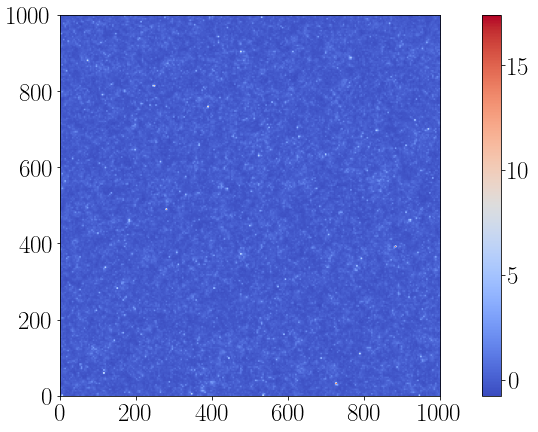

In [52]:
plt.figure(figsize=(15,7))

plt.imshow(np.mean(deltax_alt[:,:,:],axis=0),extent=(0,boxlength,0,boxlength),cmap='coolwarm') # capire che cosa si intende
plt.colorbar()
plt.show()

[]

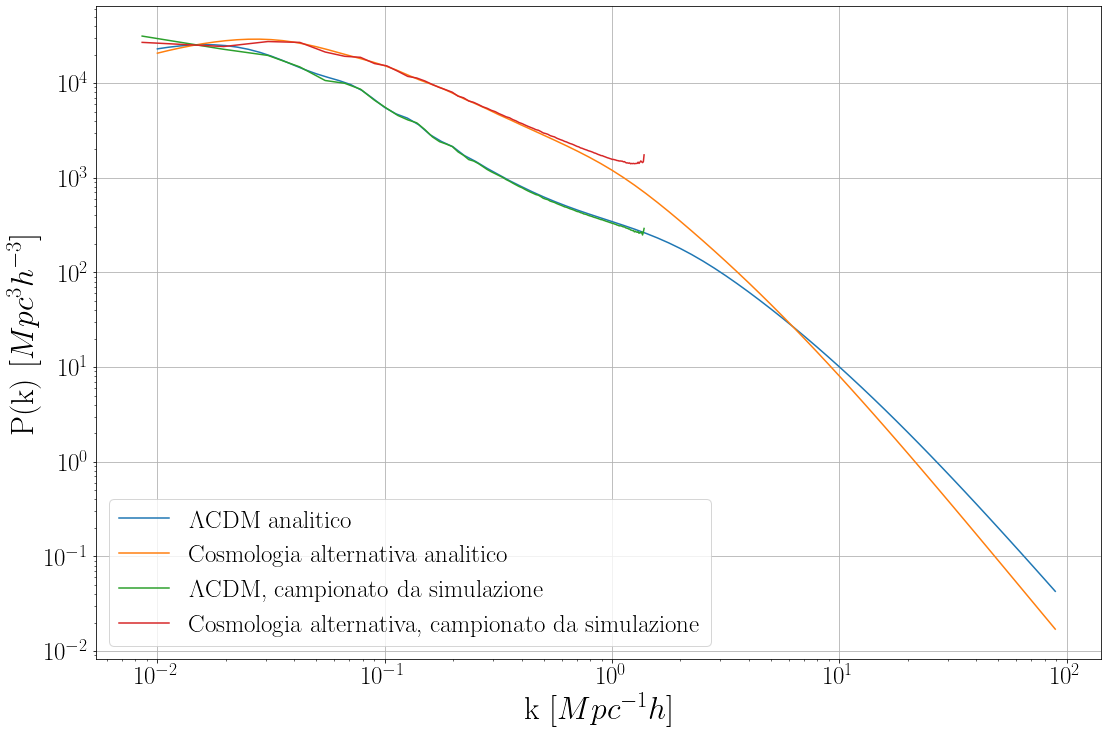

In [53]:
# Estraggo lo spettro di potenza dalla simulazione, 

p_k_alt, kbins = pbox.get_power(deltax_alt,pb.boxlength,)#,bins = 80)


plt.figure(figsize=(18,12))
plt.loglog(hm_ref.k_hm, hm_ref.power_auto_matter_fnc(hm_ref.k_hm), label='$\Lambda$CDM analitico')
plt.loglog(hm_alt.k_hm, hm_alt.power_auto_matter_fnc(hm_ref.k_hm), label='Cosmologia alternativa analitico')

plt.plot(kbins,p_k,label="$\Lambda$CDM, campionato da simulazione")
plt.plot(kbins,p_k_alt,label="Cosmologia alternativa, campionato da simulazione")

plt.grid()
plt.legend(fontsize=25)
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.ylabel(r" P(k)$  \ [{ Mpc^3}h^{-3}]$",size=32);
plt.loglog()
#plt.ylim(1e-4,1e4)

#plt.xlim(2*1e-2,1)